In [31]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import numpy.linalg as la


def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples

#
# Helper functions for the toric libary
#

def vector3_to_str(v):
    return "(%.2f, %.2f, %.2f)" % (v.x(), v.y(), v.z())
    
def toric_to_str(t):
    return "(a = %.2f°, t = %2.f°, p = %.2f°)" % (t.getAlpha().valueDegrees(), t.getTheta().valueDegrees(), t.getPhi().valueDegrees())

def vector3_to_np3(v):
    return np.array([v.x(),v.y(),v.z()])

def np3_to_vector3(v):
    return toric.Vector3(v[0],v[1],v[2])

def vector3_to_np2(v):
    return np.array([v.x(),v.y()])

def toric_to_cam_np(t, PA, PB):
    c = toric.Toric3_ToWorldPosition(t, PA, PB)
    return vector3_to_np3(c)


In [32]:
#
# OK, let's assume we want to calculate a trajectory between these positions:
#

# let's set a minimum distance of 0.9m
min_dist = 1

# starting people positons
PA_1 = toric.Vector3(0,0,0)
PB_1 = toric.Vector3(2,0,0)

# ending people positions: for the moment the positions are the same
PA_2 = toric.Vector3(0,0,0)
PB_2 = toric.Vector3(2,0,0)

# Starting camera position is *outside* of PA_1:
C_1 = toric.Vector3(-1,-0.5,0)
C_2 = toric.Vector3( 3,-1,0)


In [33]:
def drawSetup():
    pylab.rcParams['figure.figsize'] = 8, 8

    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)

    fig = plt.gcf()
    fig.gca().add_artist(circle_PA_1)
    fig.gca().add_artist(circle_PB_1)

    # Set up plot size
    fudgeX = 3
    fudgeY_pos = 2
    fudgeY_neg = 8
    plt.axes().set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    plt.axes().set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    plt.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)

    # Draw Circles
    
    plt.axes().set_aspect('equal')

    # Draw Camera positions
    plt.scatter([C_1.x(), C_2.x()],[C_1.y(), C_2.y()],c="blue",linewidths=0)

def scatterplot_camera_arr(C):
    plt.scatter(C[:,0],C[:,1],cmap='copper',linewidths=0)
    

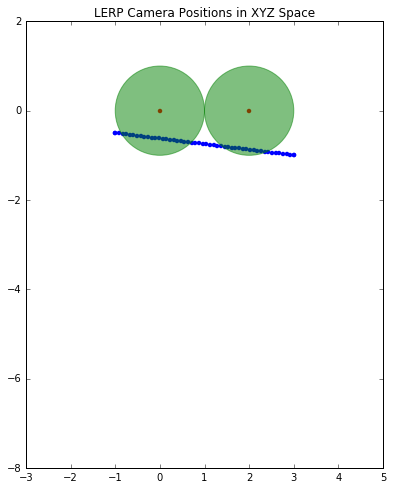

In [34]:
#
# Consider linear interpolation
#

drawSetup()
plt.title("Linear interpolation from Cam1 to Cam2")
xlin = np.linspace(C_1.x(), C_2.x())
ylin = np.linspace(C_1.y(), C_2.y())
plt.scatter(xlin,ylin,linewidths=0)
plt.title("LERP Camera Positions in XYZ Space")

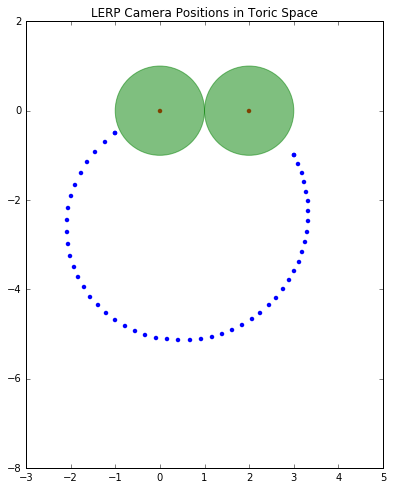

In [35]:
#
# Consider interpolating in toric space directly
# (eg. lerp alpha, theta, phi)
#

# Starting camera position is *outside* of PA_1:
#C_1 = toric.Vector3(-1,-0.5,0)
#C_2 = toric.Vector3( 1,-0.5,0)

drawSetup()

def map_toric_to_cam(a):
    t = toric.Toric3(toric.RadianPi(a[0]),toric.Radian2Pi(a[1]),toric.RadianPi(a[2]))
    return toric_to_cam_np(t, PA_1, PB_1)

C_1_toric = toric.Toric3_FromWorldPosition(C_1,PA_1,PB_1)
C_2_toric = toric.Toric3_FromWorldPosition(C_2,PA_1,PB_1)

# Alpha is easy to interpolate
alpha_lin = np.linspace(C_1_toric.getAlpha().valueRadians(),C_2_toric.getAlpha().valueRadians())

# Theta we want to interpolate by mapping the space "theta in [0, 2(pi - alpha)]" to "[0,1]", and interpolating in the latter.
# so first we will extract the start and end alphas and equivalent thetas.
theta1 = C_1_toric.getTheta().valueRadians()
theta2 = C_2_toric.getTheta().valueRadians()
theta1_max = 2*(np.pi - C_1_toric.getAlpha().valueRadians())
theta2_max = 2*(np.pi - C_2_toric.getAlpha().valueRadians())

theta1_lerpspace = theta1/theta1_max
theta2_lerpspace = theta2/theta2_max

theta_lerpspace_lin = np.linspace(theta1_lerpspace,theta2_lerpspace)
theta_lin = theta_lerpspace_lin * (2*(np.pi - alpha_lin))

# Phi is easy to interpolate
phi_lin   = np.linspace(C_1_toric.getPhi().valueRadians(),  C_2_toric.getPhi().valueRadians())

P = np.c_[ alpha_lin, theta_lin, phi_lin ]
C = np.apply_along_axis(map_toric_to_cam, axis=1, arr=P)

scatterplot_camera_arr(C)
plt.title("LERP Camera Positions in Toric Space")

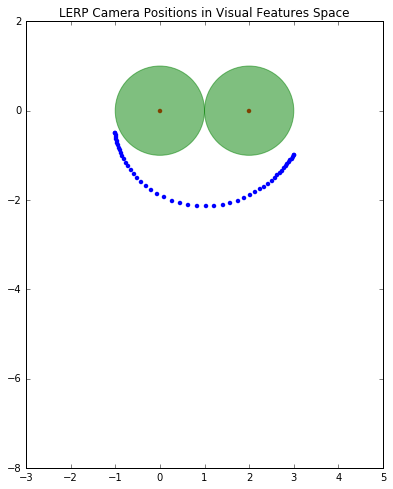

In [36]:
#
# Consider interpolating visual features
# (eg. lerp alpha, distance, vantage)
#

drawSetup()

C_1_toric = toric.Toric3_FromWorldPosition(C_1,PA_1,PB_1)
C_2_toric = toric.Toric3_FromWorldPosition(C_2,PA_1,PB_1)

C_1_PA_1 = vector3_to_np3(C_1) - vector3_to_np3(PA_1)
C_1_distance_A = la.norm(C_1_PA_1)
C_1_PB_1 = vector3_to_np3(C_1) - vector3_to_np3(PB_1)
C_1_distance_B = la.norm(C_1_PB_1)
C_1_vantage_A = C_1_PA_1 / C_1_distance_A
C_1_vantage_B = C_1_PB_1 / C_1_distance_B

C_2_PA_1 = vector3_to_np3(C_2) - vector3_to_np3(PA_1)
C_2_distance_A = la.norm(C_2_PA_1)
C_2_PB_1 = vector3_to_np3(C_2) - vector3_to_np3(PB_1)
C_2_distance_B = la.norm(C_2_PB_1)
C_2_vantage_A = C_2_PA_1 / C_2_distance_A
C_2_vantage_B = C_2_PB_1 / C_2_distance_B

# test ComputeDistanceToA
def compute_distance_to_A(AB, alpha, theta):
    return (AB * np.sin(alpha+theta/2.) ) / np.sin(alpha)

PAB_1 = vector3_to_np3(PA_1) - vector3_to_np3(PB_1)
AB = la.norm(PAB_1)
dTest = compute_distance_to_A(AB, C_1_toric.getAlpha().valueRadians(), C_1_toric.getTheta().valueRadians()) 
# equals calculated distance above

alpha_lin = np.linspace(C_1_toric.getAlpha().valueRadians(),C_2_toric.getAlpha().valueRadians())
distance_A_lin = np.linspace(C_1_distance_A,C_2_distance_A)
distance_B_lin = np.linspace(C_1_distance_B,C_2_distance_B)
vantage_A_x_lin = np.linspace(C_1_vantage_A[0],C_2_vantage_A[0])
vantage_A_y_lin = np.linspace(C_1_vantage_A[1],C_2_vantage_A[1])
vantage_A_z_lin = np.linspace(C_1_vantage_A[2],C_2_vantage_A[2])
vantage_B_x_lin = np.linspace(C_1_vantage_B[0],C_2_vantage_B[0])
vantage_B_y_lin = np.linspace(C_1_vantage_B[1],C_2_vantage_B[1])
vantage_B_z_lin = np.linspace(C_1_vantage_B[2],C_2_vantage_B[2])

# Returns the angle in radians between vectors 'v1' and 'v2' 
def py_ang(v1, v2):
    cosang = np.dot(v1, v2)
    sinang = la.norm(np.cross(v1, v2))
    return np.arctan2(sinang, cosang)

# Convert back to Cartesian and plot
def map_visual_to_cam(a):
    alpha = a[0]
    dist_A = a[1]
    dist_B = a[2]
    vant_A = np.array([a[3], a[4], a[5]])
    vant_A = vant_A / la.norm(vant_A)
    vant_B = np.array([a[6], a[7], a[8]])
    vant_B = vant_B / la.norm(vant_B)
    # manifold surface generated by interpolated alpha ??
    # intersect manifold with vantage vectors
    # calculate distance
    dist_A_alpha = dist_A
    dist_B_alpha = dist_B
    
    # calculate lambda
    # sinusoid taking as input the angle between vantage and line AB (separating the two targets)
    line_AB = np3_to_vector3(PAB_1).perpendicular()
    angle_A = py_ang(vector3_to_np3(line_AB), vant_A) #line_AB.directedAngle(line_AB, np3_to_vector3(vant_A))
    angle_B = py_ang(vector3_to_np3(line_AB), vant_B)
    lambda_A = np.sin(angle_A)
    lambda_B = np.sin(angle_B)
    
    F = vector3_to_np3(PA_1) + vector3_to_np3(PB_1)
    F += (vant_A * (dist_A + dist_A_alpha * lambda_A) / (1 + lambda_A))
    F += (vant_B * (dist_B + dist_B_alpha * lambda_B) / (1 + lambda_B))
    F *= 0.5
    return F

V = np.c_[alpha_lin, distance_A_lin, distance_B_lin, vantage_A_x_lin, vantage_A_y_lin, vantage_A_z_lin, vantage_B_x_lin, vantage_B_y_lin, vantage_B_z_lin]
FC = np.apply_along_axis(map_visual_to_cam, axis=1, arr=V)

scatterplot_camera_arr(FC)
plt.title("LERP Camera Positions in Visual Features Space")

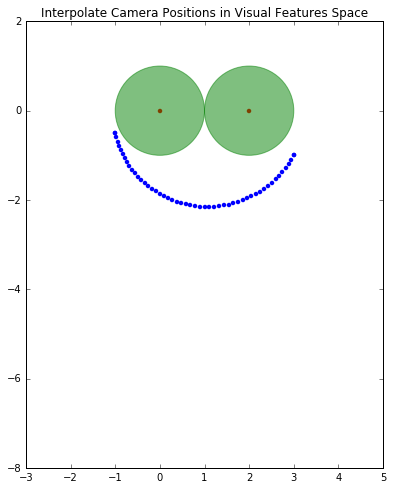

In [37]:
#
# Consider interpolating visual features
# (eg. lerp alpha, distance, vantage)
#

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1


drawSetup()

C_1_toric = toric.Toric3_FromWorldPosition(C_1,PA_1,PB_1)
C_2_toric = toric.Toric3_FromWorldPosition(C_2,PA_1,PB_1)

C_1_PA_1 = vector3_to_np3(C_1) - vector3_to_np3(PA_1)
C_1_distance_A = la.norm(C_1_PA_1)
C_1_PB_1 = vector3_to_np3(C_1) - vector3_to_np3(PB_1)
C_1_distance_B = la.norm(C_1_PB_1)
C_1_vantage_A = C_1_PA_1 / C_1_distance_A
C_1_vantage_B = C_1_PB_1 / C_1_distance_B

C_2_PA_1 = vector3_to_np3(C_2) - vector3_to_np3(PA_1)
C_2_distance_A = la.norm(C_2_PA_1)
C_2_PB_1 = vector3_to_np3(C_2) - vector3_to_np3(PB_1)
C_2_distance_B = la.norm(C_2_PB_1)
C_2_vantage_A = C_2_PA_1 / C_2_distance_A
C_2_vantage_B = C_2_PB_1 / C_2_distance_B

# test ComputeDistanceToA
def compute_distance_to_A(AB, alpha, theta):
    return (AB * np.sin(alpha+theta/2.) ) / np.sin(alpha)

PAB_1 = vector3_to_np3(PA_1) - vector3_to_np3(PB_1)
AB = la.norm(PAB_1)
dTest = compute_distance_to_A(AB, C_1_toric.getAlpha().valueRadians(), C_1_toric.getTheta().valueRadians()) 
# equals calculated distance above

t = np.c_[np.linspace(0,1)]

alpha_lin = np.linspace(C_1_toric.getAlpha().valueRadians(),C_2_toric.getAlpha().valueRadians())
distance_A_lin = np.linspace(C_1_distance_A,C_2_distance_A)
distance_B_lin = np.linspace(C_1_distance_B,C_2_distance_B)
vantage_A_slerp = np.apply_along_axis(lambda t : slerp(C_1_vantage_A,C_2_vantage_A,t), axis=1, arr=t)
vantage_B_slerp = np.apply_along_axis(lambda t : slerp(C_1_vantage_B,C_2_vantage_B,t), axis=1, arr=t)

# Returns the angle in radians between vectors 'v1' and 'v2' 
def py_ang(v1, v2):
    cosang = np.dot(v1, v2)
    sinang = la.norm(np.cross(v1, v2))
    return np.arctan2(sinang, cosang)

# Convert back to Cartesian and plot
def map_visual_to_cam(a):
    alpha = a[0]
    dist_A = a[1]
    dist_B = a[2]
    vant_A = np.array([a[3], a[4], a[5]])
    vant_A /= np.linalg.norm(vant_A)
    vant_B = np.array([a[6], a[7], a[8]])
    vant_B /= np.linalg.norm(vant_B)
    # manifold surface generated by interpolated alpha ??
    # intersect manifold with vantage vectors
    # calculate distance
    dist_A_alpha = dist_A
    dist_B_alpha = dist_B
    
    # calculate lambda
    # sinusoid taking as input the angle between vantage and line AB (separating the two targets)
    line_AB = np3_to_vector3(PAB_1).perpendicular()
    angle_A = py_ang(vector3_to_np3(line_AB), vant_A) #line_AB.directedAngle(line_AB, np3_to_vector3(vant_A))
    angle_B = py_ang(vector3_to_np3(line_AB), vant_B)
    lambda_A = np.sin(angle_A)
    lambda_B = np.sin(angle_B)
    
    F = vector3_to_np3(PA_1) + vector3_to_np3(PB_1)
    F += (vant_A * (dist_A + dist_A_alpha * lambda_A) / (1 + lambda_A))
    F += (vant_B * (dist_B + dist_B_alpha * lambda_B) / (1 + lambda_B))
    F *= 0.5
    return F

V = np.c_[alpha_lin, distance_A_lin, distance_B_lin, vantage_A_slerp, vantage_B_slerp]
FC = np.apply_along_axis(map_visual_to_cam, axis=1, arr=V)

scatterplot_camera_arr(FC)
plt.title("Interpolate Camera Positions in Visual Features Space")